In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import copy
from types import SimpleNamespace
import warnings

In [3]:
trimss = pd.read_csv("trimmed.csv")

In [4]:
trimss.drop(columns=trimss.columns[0], axis=1, inplace=True)

In [5]:
trimss

,Id_Paciente,sumHour,saturaciono,temperatura,frecuenciac,sysPres,diasPres,tiposaturac_GafasO2,tiposaturac_VMK,tiposaturac_Optiflow
0,14260524,14,96.0,37.2,110.0,144.0,79.0,False,True,False
1,14260524,15,NaN,NaN,NaN,NaN,NaN,False,False,False
2,14260524,16,NaN,NaN,NaN,NaN,NaN,False,False,False
3,14260524,17,97.0,37.8,110.0,NaN,NaN,False,True,False
4,14260524,18,NaN,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...
342280,8631140337,222,NaN,NaN,NaN,NaN,NaN,False,False,False
342281,8631140337,223,NaN,NaN,NaN,NaN,NaN,False,False,False
342282,8631140337,224,NaN,NaN,NaN,NaN,NaN,False,False,False
342283,8631140337,225,96.0,35.7,65.0,110.0,75.0,False,True,False


In [6]:
#put it in a big list
trimlist = []
for patient in trimss.Id_Paciente.unique():
    trimlist.append(trimss[trimss["Id_Paciente"]==patient].reset_index())


In [7]:
#RUN IN PREVIOUS SETUP
# import warnings
# warnings.filterwarnings('ignore')
# for i,table in enumerate(trimlist):
#     print(i/len(trimlist))
#     for hour in table["sumHour"].unique():
#         ## FIX INCONSISTENT METRICS (eg. saturaciono)
#         # we've already dont the pressure fix by this point, so we could just get an average for every column that's
#         # numeric past this point
#         if len(table[table["sumHour"]==hour]) >= 2: #if this hour has at least 2 rows
#             for col in table[table["sumHour"]==hour].columns.values:
#                 if table[col].dtype == 'float64':
#                     # print(i)
#                     trimlist[i].loc[trimlist[i]["sumHour"] == hour, col] = trimlist[i].loc[trimlist[i]["sumHour"] == hour, col].mean() #should work??
#     trimlist[i] = trimlist[i].drop_duplicates()



In [8]:
trimlist[0]

,index,Id_Paciente,sumHour,saturaciono,temperatura,frecuenciac,sysPres,diasPres,tiposaturac_GafasO2,tiposaturac_VMK,tiposaturac_Optiflow
0,0,14260524,14,96.0,37.2,110.0,144.0,79.0,False,True,False
1,1,14260524,15,NaN,NaN,NaN,NaN,NaN,False,False,False
2,2,14260524,16,NaN,NaN,NaN,NaN,NaN,False,False,False
3,3,14260524,17,97.0,37.8,110.0,NaN,NaN,False,True,False
4,4,14260524,18,NaN,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
231,231,14260524,245,NaN,NaN,NaN,NaN,NaN,False,False,False
232,232,14260524,246,NaN,NaN,NaN,NaN,NaN,False,False,False
233,233,14260524,247,NaN,NaN,NaN,NaN,NaN,False,False,False
234,234,14260524,248,NaN,NaN,NaN,NaN,NaN,False,False,False


In [9]:
#first, a function to get the numbers that mark percentages of a number range
def get_percent(table,percentlist):
    outlist = []
    outlist.append(min(table.sumHour)) #first, set our startpoint as the min hour for this patient
    modhours = table.sumHour - min(table.sumHour) #zero standardize for easier calculations later
    for percent in percentlist: #for each percent requested in this array/list/whatever, get the number that corresponds
        outlist.append(round(max(modhours) * percent)+min(table.sumHour)) #percent fed as decimals, like 0.25
    outlist.append(max(table.sumHour)) #cap off
    return outlist

plist = [0.25,0.5,0.75]
get_percent(trimlist[0],plist)

[14, 73, 132, 190, 249]

In [10]:
# brutish, but fast
contVars = ["saturaciono","temperatura","frecuenciac","sysPres","diasPres"]
catVars = ["tiposaturac_GafasO2","tiposaturac_VMK","tiposaturac_Optiflow"]

In [11]:
#next, a function to use that output to get averages for each column and range, and divide that into the amount of rows for the
#next table
def compress(table,percentlist):
    marks = get_percent(table,percentlist)
    outlist = []
    r_cutoff_lo = 0.01 #dictates cutoff to consider a timeblock as including or not a respirator type for a bit of time
    r_cutoff_hi = 0.1 #dictates cutoff to consider a timeblock as including or not a respirator type for a significant period
    

    for i,mark in enumerate(marks):
        if i > 0: #skip first entry
            linedict = dict()
            linedict["Id_Paciente"] = table.Id_Paciente[0] #doesnt change so doesnt matter
            linedict["Slice"] = i #for pivoting later

            filter = np.where((table['sumHour']>=marks[i-1]) & (table['sumHour']<=marks[i]))
            temptable = table.loc[filter]
            for label in contVars: #float variables
                linedict[label] = round(temptable[label].mean(),1)

            for label in catVars: #categorical variables
                # linedict[label] = round(temptable[label].mean(),4)
                if round(temptable[label].mean(),4) >= r_cutoff_lo: 
                    linedict[label] = 1
                else:
                    linedict[label] = 0

                if round(temptable[label].mean(),4) >= r_cutoff_hi: #catch larger segments
                    linedict[label] = 2



            outlist.append(linedict)
    
    outlist = pd.DataFrame.from_dict(outlist)
    outlist.fillna(round(outlist.mean(),1), inplace=True) #replaces any NaNs with the column mean, ASK IF OKAY
    return outlist

In [12]:
def columnize(table):
    table=table.pivot(index="Id_Paciente", columns='Slice', values=contVars+catVars)
    table.columns = ["_".join(map(str, a)) for a in table.columns.to_flat_index()]
    return table

In [13]:
#I wanna add a variable to clarify when a region is missing metrics
#easiest clean is just replace nans with the column mean.... so im gonna do that...
compress(trimlist[400],plist)

,Id_Paciente,Slice,saturaciono,temperatura,frecuenciac,sysPres,diasPres,tiposaturac_GafasO2,tiposaturac_VMK,tiposaturac_Optiflow
0,700389040,1,92.2,36.7,77.0,115.5,67.2,2,0,0
1,700389040,2,91.4,36.3,80.0,110.5,67.0,2,0,0
2,700389040,3,93.0,36.1,79.0,507.7,86.7,1,0,0
3,700389040,4,94.2,36.3,80.5,134.0,74.5,2,0,0


In [14]:
columnize(compress(trimlist[400],plist))

,saturaciono_1,saturaciono_2,saturaciono_3,saturaciono_4,temperatura_1,temperatura_2,temperatura_3,temperatura_4,frecuenciac_1,frecuenciac_2,...,tiposaturac_GafasO2_3,tiposaturac_GafasO2_4,tiposaturac_VMK_1,tiposaturac_VMK_2,tiposaturac_VMK_3,tiposaturac_VMK_4,tiposaturac_Optiflow_1,tiposaturac_Optiflow_2,tiposaturac_Optiflow_3,tiposaturac_Optiflow_4
Id_Paciente,,,,,,,,,,,,,,,,,,,,,
700389040,92.2,91.4,93.0,94.2,36.7,36.3,36.1,36.3,77.0,80.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
for i,table in enumerate(trimlist):
    print(i/len(trimlist))
    table = compress(table,plist)
    trimlist[i] = columnize(table)

0.0
0.000612369871402327
0.001224739742804654
0.001837109614206981
0.002449479485609308
0.003061849357011635
0.003674219228413962
0.004286589099816289
0.004898958971218616
0.005511328842620943
0.00612369871402327
0.006736068585425597
0.007348438456827924
0.007960808328230252
0.008573178199632579
0.009185548071034905
0.009797917942437232
0.010410287813839559
0.011022657685241886
0.011635027556644213
0.01224739742804654
0.012859767299448868
0.013472137170851195
0.014084507042253521
0.014696876913655848
0.015309246785058175
0.015921616656460504
0.01653398652786283
0.017146356399265157
0.017758726270667484
0.01837109614206981
0.018983466013472138
0.019595835884874464
0.02020820575627679
0.020820575627679118
0.021432945499081445
0.02204531537048377
0.0226576852418861
0.023270055113288425
0.023882424984690752
0.02449479485609308
0.02510716472749541
0.025719534598897736
0.026331904470300063
0.02694427434170239
0.027556644213104716
0.028169014084507043
0.02878138395590937
0.029393753827311696


In [16]:
trimlist[38]

,saturaciono_1,saturaciono_2,saturaciono_3,saturaciono_4,temperatura_1,temperatura_2,temperatura_3,temperatura_4,frecuenciac_1,frecuenciac_2,...,tiposaturac_GafasO2_3,tiposaturac_GafasO2_4,tiposaturac_VMK_1,tiposaturac_VMK_2,tiposaturac_VMK_3,tiposaturac_VMK_4,tiposaturac_Optiflow_1,tiposaturac_Optiflow_2,tiposaturac_Optiflow_3,tiposaturac_Optiflow_4
Id_Paciente,,,,,,,,,,,,,,,,,,,,,
54422182,99.0,96.2,96.0,95.8,35.8,35.7,36.0,35.6,85.7,72.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# lab = pd.read_excel('laboratorio_final_new.xlsx') #Other, weirder long data?
pac = pd.read_excel('pac_covid.xlsx') #Patient basic info, ONE ROW PER PATIENT
pac["Dead"] = pac["fecha_fallece"].notna()
pac

,Id_Paciente,Desc_Prueba,Fecha_validaci_n_prueba,Episodio___nico_,Sexo,Edad_a_os__actual_,Fecha__ingreso_,Fecha__alta_,fecha_fallece,dias_hasta_ingreso,dias_estancia,paso_uci,Dead
0,11711053,Coronavirus 2019-nCoV (ARN),2020-03-16,66755125,Hombre,86,2020-03-16,2020-03-21,2020-03-21,0,5.0,0,True
1,14260524,Coronavirus 2019-nCoV (ARN),2020-04-07,66844681,Mujer,97,2020-04-07,2020-04-17,NaT,0,10.0,0,False
2,14409908,Coronavirus 2019-nCoV (ARN),2020-03-31,66822847,Mujer,94,2020-04-01,2020-04-04,2020-04-04,1,3.0,0,True
3,22329353,Coronavirus 2019-nCoV (ARN),2020-09-24,67973760,Mujer,91,2020-10-01,2020-10-09,NaT,7,8.0,0,False
4,23608324,Coronavirus 2019-nCoV (ARN),2020-03-13,66745194,Hombre,90,2020-03-13,2020-03-21,NaT,0,8.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,9245104453,Coronavirus 2019-nCoV (ARN),2021-04-13,69499309,Mujer,50,2021-04-17,2021-04-20,NaT,4,3.0,0,False
1638,9278045053,Coronavirus 2019-nCoV (ARN),2020-03-23,66783136,Mujer,34,2020-03-23,2020-03-26,NaT,0,3.0,0,False
1639,9283692237,Coronavirus-SARS-2 Ag (ICT),2021-01-06,68713110,Mujer,63,2021-01-12,2021-01-19,NaT,6,7.0,0,False
1640,9294732495,Coronavirus 2019-nCoV (ARN),2021-01-19,68769742,Mujer,32,2021-01-19,2021-01-20,NaT,0,1.0,0,False


In [18]:
# min(pac["Fecha__ingreso_"])
max(pac["Fecha__ingreso_"])

Timestamp('2021-05-10 00:00:00')

In [19]:
pactokeep = [
    "Id_Paciente",
    "Dead",
    "Sexo",
    "Edad_a_os__actual_",
    "dias_estancia",
    "paso_uci"
]
pac_vars = pac[pactokeep]

In [20]:
pac_vars

,Id_Paciente,Dead,Sexo,Edad_a_os__actual_,dias_estancia,paso_uci
0,11711053,True,Hombre,86,5.0,0
1,14260524,False,Mujer,97,10.0,0
2,14409908,True,Mujer,94,3.0,0
3,22329353,False,Mujer,91,8.0,0
4,23608324,False,Hombre,90,8.0,0
...,...,...,...,...,...,...
1637,9245104453,False,Mujer,50,3.0,0
1638,9278045053,False,Mujer,34,3.0,0
1639,9283692237,False,Mujer,63,7.0,0
1640,9294732495,False,Mujer,32,1.0,0


In [21]:
len(trimlist)

1633

## Load in Lab Data

In [22]:
lab = pd.read_csv("labdata3.csv")
lab.drop(columns=lab.columns[0], axis=1, inplace=True)
lab

,Id_Paciente,San-Basófilos_absVal_pat,San-Basófilos_Pct_pat,San-Basófilos_absVal,San-Basófilos_Pct,San-Eosinófilos_absVal_pat,San-Eosinófilos_Pct_pat,San-Eosinófilos_absVal,San-Eosinófilos_Pct,San-Linfocitos_absVal_pat,...,Srm-Creatinina_val,Srm-Creatinina_pat,Srm-Urea_val,Srm-Urea_pat,Srm-Sodio_val,Srm-Sodio_pat,Srm-Potasio_val,Srm-Potasio_pat,Srm-Glucosa_val,Srm-Glucosa_pat
0,11711053,No patológico,No patológico,0.02780,0.4,No patológico,No patológico,0.00695,0.1,Fuera del rango de normalidad,...,1.22,No patológico,45.0,No patológico,140.0,No patológico,4.4,No patológico,78.400002,No patológico
1,14260524,No patológico,No patológico,0.01004,0.3,No patológico,No patológico,0.00730,2.3,No patológico,...,1.80,Fuera del rango de normalidad,94.0,Fuera del rango de normalidad,153.0,Fuera del rango de normalidad,4.7,No patológico,116.800003,Fuera del rango de normalidad
2,14409908,No patológico,No patológico,0.02608,0.2,No patológico,No patológico,0.00000,0.0,Fuera del rango de normalidad,...,1.04,No patológico,63.0,Fuera del rango de normalidad,139.0,No patológico,5.0,No patológico,152.300003,Fuera del rango de normalidad
3,22329353,No patológico,No patológico,0.00000,0.3,No patológico,No patológico,0.00000,0.3,Fuera del rango de normalidad,...,2.54,Fuera del rango de normalidad,110.0,Fuera del rango de normalidad,140.0,No patológico,4.7,No patológico,436.299988,Rango de pánico
4,23608324,No patológico,No patológico,0.00000,0.2,No patológico,No patológico,0.00000,0.0,Fuera del rango de normalidad,...,0.88,No patológico,50.0,No patológico,141.0,No patológico,3.9,No patológico,157.100006,Fuera del rango de normalidad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,9245104453,No patológico,No patológico,0.02132,0.4,No patológico,No patológico,0.02132,0.4,Fuera del rango de normalidad,...,0.53,No patológico,19.0,No patológico,139.0,No patológico,4.2,No patológico,80.199997,No patológico
1403,9278045053,No patológico,No patológico,0.01008,0.4,No patológico,No patológico,0.01008,0.4,Fuera del rango de normalidad,...,0.66,No patológico,16.0,No patológico,140.0,No patológico,3.7,No patológico,121.199997,Fuera del rango de normalidad
1404,9283692237,No patológico,No patológico,0.01244,0.5,No patológico,No patológico,0.01244,2.0,No patológico,...,0.67,No patológico,34.0,No patológico,137.0,No patológico,3.8,No patológico,143.600006,Fuera del rango de normalidad
1405,9294732495,No patológico,No patológico,0.01026,0.3,No patológico,No patológico,0.12996,3.8,Fuera del rango de normalidad,...,0.80,No patológico,11.0,No patológico,141.0,No patológico,3.7,No patológico,88.300003,No patológico


In [23]:
for column in lab.columns.values:
    if column.find("_pat"): #binarize pathologic assesment columns, altho this will, for sure, add some collinearity
        lab[column] = lab[column].replace({'No patológico': 0, 'Fuera del rango de normalidad': 1, 'Rango de pánico': 2})


C:\Users\sergi\AppData\Local\Temp\ipykernel_16524\4173135500.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lab[column] = lab[column].replace({'No patológico': 0, 'Fuera del rango de normalidad': 1, 'Rango de pánico': 2})


In [24]:
Rtable = pac_vars.join(pd.concat(trimlist), on="Id_Paciente", how="inner").reset_index().drop(columns=['index'])
Rtable['Sexo'] = Rtable['Sexo'].replace({'Hombre': 0, 'Mujer': 1})
Rtable["dias_estancia"]=Rtable["dias_estancia"].fillna(0)
Rtable_only_ctes = copy.deepcopy(Rtable.drop(columns=['Id_Paciente'])) #for comparing against full table, linear performance at 0.95% accuracy here
Rtable

C:\Users\sergi\AppData\Local\Temp\ipykernel_16524\269088728.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Rtable['Sexo'] = Rtable['Sexo'].replace({'Hombre': 0, 'Mujer': 1})


,Id_Paciente,Dead,Sexo,Edad_a_os__actual_,dias_estancia,paso_uci,saturaciono_1,saturaciono_2,saturaciono_3,saturaciono_4,...,tiposaturac_GafasO2_3,tiposaturac_GafasO2_4,tiposaturac_VMK_1,tiposaturac_VMK_2,tiposaturac_VMK_3,tiposaturac_VMK_4,tiposaturac_Optiflow_1,tiposaturac_Optiflow_2,tiposaturac_Optiflow_3,tiposaturac_Optiflow_4
0,11711053,True,0,86,5.0,0,94.2,95.3,96.0,93.3,...,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,14260524,False,1,97,10.0,0,95.3,92.9,95.7,93.9,...,2.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
2,14409908,True,1,94,3.0,0,69.7,43.0,40.0,50.9,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,22329353,False,1,91,8.0,0,96.0,93.8,94.2,97.1,...,0.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0
4,23608324,False,0,90,8.0,0,95.6,95.5,94.2,94.7,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,9245104453,False,1,50,3.0,0,95.0,95.3,95.3,94.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629,9278045053,False,1,34,3.0,0,98.0,97.0,97.5,97.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1630,9283692237,False,1,63,7.0,0,96.0,96.8,95.4,95.6,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1631,9294732495,False,1,32,1.0,0,98.5,98.0,97.0,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Produces the full Rtable, but drops a little under 200 patients, still a decent size methinks
Rtable = Rtable.merge(lab, on="Id_Paciente", how="inner").reset_index().drop(columns=['index','Id_Paciente'])
Rtable

,Dead,Sexo,Edad_a_os__actual_,dias_estancia,paso_uci,saturaciono_1,saturaciono_2,saturaciono_3,saturaciono_4,temperatura_1,...,Srm-Creatinina_val,Srm-Creatinina_pat,Srm-Urea_val,Srm-Urea_pat,Srm-Sodio_val,Srm-Sodio_pat,Srm-Potasio_val,Srm-Potasio_pat,Srm-Glucosa_val,Srm-Glucosa_pat
0,True,0,86,5.0,0,94.2,95.3,96.0,93.3,37.1,...,1.22,0,45.0,0,140.0,0,4.4,0,78.400002,0
1,False,1,97,10.0,0,95.3,92.9,95.7,93.9,37.3,...,1.80,1,94.0,1,153.0,1,4.7,0,116.800003,1
2,True,1,94,3.0,0,69.7,43.0,40.0,50.9,35.0,...,1.04,0,63.0,1,139.0,0,5.0,0,152.300003,1
3,False,1,91,8.0,0,96.0,93.8,94.2,97.1,36.1,...,2.54,1,110.0,1,140.0,0,4.7,0,436.299988,2
4,False,0,90,8.0,0,95.6,95.5,94.2,94.7,36.6,...,0.88,0,50.0,0,141.0,0,3.9,0,157.100006,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,False,1,50,3.0,0,95.0,95.3,95.3,94.5,37.0,...,0.53,0,19.0,0,139.0,0,4.2,0,80.199997,0
1395,False,1,34,3.0,0,98.0,97.0,97.5,97.0,37.2,...,0.66,0,16.0,0,140.0,0,3.7,0,121.199997,1
1396,False,1,63,7.0,0,96.0,96.8,95.4,95.6,36.8,...,0.67,0,34.0,0,137.0,0,3.8,0,143.600006,1
1397,False,1,32,1.0,0,98.5,98.0,97.0,98.0,36.3,...,0.80,0,11.0,0,141.0,0,3.7,0,88.300003,0


In [ ]:
# Rtable.to_csv("Rtable_3.csv")

## Regressions

Since we're making binary predictions (Dead/Alive), we want to use classification methods, so things like SVMs, Gradient Boosting(XGBoost), KNNs, Random Forest and regular logistic regressions

We can also try our hand at hyperparameter tuning with each one of these, cross-validation stuff too

Another thing you have to keep in mind as you write these, by the way, is how vulnerable these algorithms are to collinearity, cuz your temporally related variables are going to be correlated within themselves, obviously

In [426]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [427]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [428]:
Rtable_only_ctes

,Dead,Sexo,Edad_a_os__actual_,dias_estancia,paso_uci,saturaciono_1,saturaciono_2,saturaciono_3,saturaciono_4,temperatura_1,...,tiposaturac_GafasO2_3,tiposaturac_GafasO2_4,tiposaturac_VMK_1,tiposaturac_VMK_2,tiposaturac_VMK_3,tiposaturac_VMK_4,tiposaturac_Optiflow_1,tiposaturac_Optiflow_2,tiposaturac_Optiflow_3,tiposaturac_Optiflow_4
0,True,0,86,5.0,0,94.2,95.3,96.0,93.3,37.1,...,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,False,1,97,10.0,0,95.3,92.9,95.7,93.9,37.3,...,2.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
2,True,1,94,3.0,0,69.7,43.0,40.0,50.9,35.0,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,False,1,91,8.0,0,96.0,93.8,94.2,97.1,36.1,...,0.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0
4,False,0,90,8.0,0,95.6,95.5,94.2,94.7,36.6,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,False,1,50,3.0,0,95.0,95.3,95.3,94.5,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629,False,1,34,3.0,0,98.0,97.0,97.5,97.0,37.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1630,False,1,63,7.0,0,96.0,96.8,95.4,95.6,36.8,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1631,False,1,32,1.0,0,98.5,98.0,97.0,98.0,36.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [429]:
def quickregress(data,splitsize):
    X = data.drop(columns=["Dead"])
    y = data['Dead']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=splitsize)
    log_model = LogisticRegression()
    log_model.fit(X_train, y_train)
    y_pred = log_model.predict(X_test)
    coefficients = pd.DataFrame(data=[X_train.columns.values,log_model.coef_[0]]).T
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    out = {"predictions": y_pred,"coefficients": coefficients,"accuracy": accuracy,"confusion": confusion,"report": report}
    return SimpleNamespace(**out) #to convert it to an object so we can say out.accuracy instead of having to do out["accuracy"]
    # return out

    

Classification report probably important to us, since we know that the risk of erroneously tagging someone as not at death risk is greater than the risk of treating someone who would have been fine.

In [432]:
ctes_lin = quickregress(Rtable_only_ctes,0.2)

c:\Users\sergi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [444]:
def pred_test(data,function,split=0.2,reps=20):
    acc_list = []
    for i in range(0,reps):
        print(i/reps)
        acc_list.append(function(data,split).accuracy)
    out = {"ac_list": acc_list,"ac_mean": np.average(acc_list)}
    return SimpleNamespace(**out) #to convert it to an object so we can say out.accuracy instead of having to do out["accuracy"]    
        

In [448]:
warnings.filterwarnings('ignore')
ctes_lin = pred_test(Rtable_only_ctes,quickregress,reps=200)

0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.285
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.345
0.35
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41
0.415
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47
0.475
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.555
0.56
0.565
0.57
0.575
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.69
0.695
0.7
0.705
0.71
0.715
0.72
0.725
0.73
0.735
0.74
0.745
0.75
0.755
0.76
0.765
0.77
0.775
0.78
0.785
0.79
0.795
0.8
0.805
0.81
0.815
0.82
0.825
0.83
0.835
0.84
0.845
0.85
0.855
0.86
0.865
0.87
0.875
0.88
0.885
0.89
0.895
0.9
0.905
0.91
0.91

<Axes: ylabel='Count'>

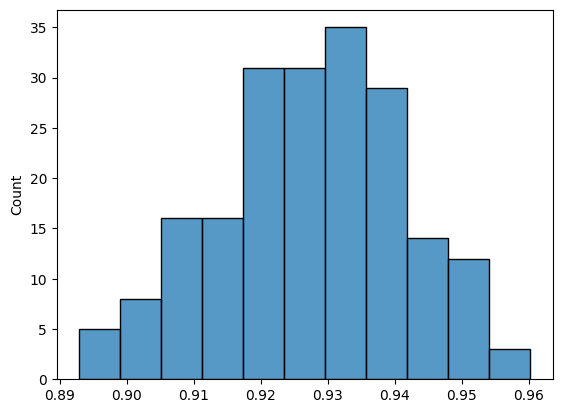

In [449]:
sns.histplot(ctes_lin.ac_list)

### HEY DUMBASS, FOR TOMORROW, let's see how to add the ventilator data in, I wanna see if there's any relation between people with low saturacion early and if that impacted if they got a ventilator and if that caused some deaths, feels like a stretch though

It would also be good if we can check how the prediction performance changes as you remove the later entries, cuz after all, they won't have the last entries until it's too late in the real world

Also, ask her how to FRAME the report and analysis. Meaning, how to discuss coefficients, how to compare the models effectively etc

In [ ]:
#zamn, a 5% increase in accuracy from the version without respirator data, from 0.89 to 0.94

#interesting, adding the lab data drops the accuracy from 94.4 to 93.4, zamn
# should we try some variable selection stuff?

# ah! wait!, it might be a drop due to the difference in size! or it mightve been a fluke!
# i think it was the inclusion of the patientID as a variable by accident :/

# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')
# print('Confusion Matrix:')
# print(confusion_matrix(y_test, y_pred))
# print('Classification Report:')
# print(classification_report(y_test, y_pred))

Accuracy: 0.934931506849315
Confusion Matrix:
[[246   6]
 [ 13  27]]
Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.98      0.96       252
        True       0.82      0.68      0.74        40

    accuracy                           0.93       292
   macro avg       0.88      0.83      0.85       292
weighted avg       0.93      0.93      0.93       292

